In [4]:
!gdown --id 1wzb5HLoO9hYg1xsJ4NEyExSZi7viuz1d     # 평균 이미지
!gdown --id 1ANFxX8fUsO3ROJl8IEzXpjyaQTbcicfV     # train/test 분할 정보
!gdown --id 1wJFIT2pvqdkrQ3Juiyxf_7MgIo7sDmdi     # dataset
!tar -zxvf dataset.tar.gz

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wzb5HLoO9hYg1xsJ4NEyExSZi7viuz1d
To: /home/devrok/aiexpert/ai-vision/Action_recoginition/crop_mean.npy
100%|██████████████████████████████████████| 2.41M/2.41M [00:00<00:00, 9.02MB/s]
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ANFxX8fUsO3ROJl8IEzXpjyaQTbcicfV
To: /home/devrok/aiexpert/ai-vision/Action_recoginition/data_split.pkl
100%|████████████████████████████████████████| 116k/116k [00:00<00:00, 1.29MB/s]
/home/devrok/.conda/envs/snuenv_pt/

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import PIL.Image as Image
import random
import numpy as np
import os
import os.path
from os.path import join
import time
import pickle
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F

# Run the code using selected GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN_CHECK_POINT = 'check_point/'

# Experiment, Optimization options
DATA_SPLIT_PATH = 'data_split.pkl'
BATCH_SIZE = 10
NUM_CLASSES = 11
CROP_SIZE = 112
CHANNEL_NUM = 3
CLIP_LENGTH = 16
EPOCH_NUM = 5
LEARNING_RATE = 1e-4

## Data Processing : Define UCF11Dataset class

In [2]:
CLIP_LENGTH = 16 # 동일한 frame수가 들어갈 수 있도록, 비디오 데이터셋에서 각 비디오를 고정된 길이의 클립으로 나누는 데 사용되는 변수

np_mean = np.load('crop_mean.npy').reshape([CLIP_LENGTH, 112, 112, 3])

def get_test_num(filename):
    lines = open(filename, 'r')
    return len(list(lines))


# 비디오 클립의 각 프레임을 처리하는 함수
def frame_process(clip, clip_length=CLIP_LENGTH, crop_size=112, channel_num=3):
    frames_num = len(clip)
    croped_frames = np.zeros([frames_num, crop_size, crop_size, channel_num]).astype(np.float32)

    # 모든 프레임을 shape[crop_size, crop_size, channel_num]로 crop
    for i in range(frames_num):
        img = Image.fromarray(clip[i].astype(np.uint8))

        # 이미지의 가로세로 비율을 유지하면서 크기를 조정
        if img.width > img.height:
            scale = float(crop_size) / float(img.height)
            img = np.array(cv2.resize(np.array(img), (int(img.width * scale + 1), crop_size))).astype(np.float32)
        else:
            scale = float(crop_size) / float(img.width)
            img = np.array(cv2.resize(np.array(img), (crop_size, int(img.height * scale + 1)))).astype(np.float32)

        # ceter crop
        crop_x = int((img.shape[1] - crop_size) / 2)
        crop_y = int((img.shape[0] - crop_size) / 2)
        img = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size, :]

        # crop된 이미지에서 평균 이미지를 빼서 정규화
        croped_frames[i, :, :, :] = img - np_mean[i]

    return croped_frames


def convert_images_to_clip(filename, clip_length=CLIP_LENGTH, crop_size=112, channel_num=3):
    clip = []
    for parent, dirnames, filenames in os.walk(filename):
        filenames = sorted(filenames)

        # 클립 길이(clip_length)와 폴더 내 파일 수를 비교하여, 필요한 이미지 수를 결정

        # 폴더 내의 파일 수가 clip_length보다 작은 경우, 모든 이미지를 로드하고 부족한 만큼 마지막 이미지를 반복하여 추가
        if len(filenames) < clip_length:
            for i in range(0, len(filenames)):
                image_name = str(filename) + '/' + str(filenames[i])
                img = Image.open(image_name)
                img_data = np.array(img)
                clip.append(img_data)
            for i in range(clip_length - len(filenames)):
                image_name = str(filename) + '/' + str(filenames[len(filenames) - 1])
                img = Image.open(image_name)
                img_data = np.array(img)
                clip.append(img_data)
        else:
            # 비디오의 길이가 clip_length보다 길어 파일 수가 충분한 경우, 무작위로 시작 인덱스(s_index)를 정하고, 그 위치부터 clip_length만큼의 이미지를 로드해서 clip에 합치기
            s_index = np.random.randint(0, len(filenames) - clip_length)
            for i in range(s_index, s_index + clip_length):
                image_name = str(filename) + '/' + str(filenames[i])
                img = Image.open(image_name)
                img_data = np.array(img)
                clip.append(img_data)

    if len(clip) == 0:
        print(filename)
    clip = frame_process(clip, clip_length, crop_size, channel_num)
    return clip # shape: [clip_length, crop_size, crop_size, channel_num]

In [3]:
class UCF11Dataset(Dataset):
    def __init__(self, data_list, num_classes, crop_size=112, channel_num=3):
        self.data_list = data_list
        self.video_list = list(data_list)
        self.crop_size = crop_size
        self.channel_num = channel_num
        self.num_classes = num_classes

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, i):
        line = self.video_list[i].strip('\n').split()
        dirname = line[0]
        label = int(self.data_list[dirname])
        clips = convert_images_to_clip(dirname, CLIP_LENGTH, self.crop_size, self.channel_num)

        clips = np.transpose(np.array(clips).astype(np.float32), (3, 0, 1, 2))  # shape: (channel_num, clip_length, crop_size, crop_size)

        batch_data = {'clips': clips, 'labels': label}

        return batch_data

## Load UCF11(UCF YouTube Action) Dataset Path
https://www.crcv.ucf.edu/data/UCF_YouTube_Action.php

In [4]:
DATA_SPLIT_PATH = 'data_split.pkl'
ucf11_dataset = pickle.load(open(DATA_SPLIT_PATH,'rb'))
train_set = ucf11_dataset['train']
test_set = ucf11_dataset['test']

## Set Dataset and Dataloader

In [5]:
train_video_dataset = UCF11Dataset(train_set, NUM_CLASSES)
test_video_dataset = UCF11Dataset(test_set, NUM_CLASSES)

train_video_dataloader = DataLoader(train_video_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_video_dataloader = DataLoader(test_video_dataset, batch_size = BATCH_SIZE, shuffle=False)

## Define NonLocal Block

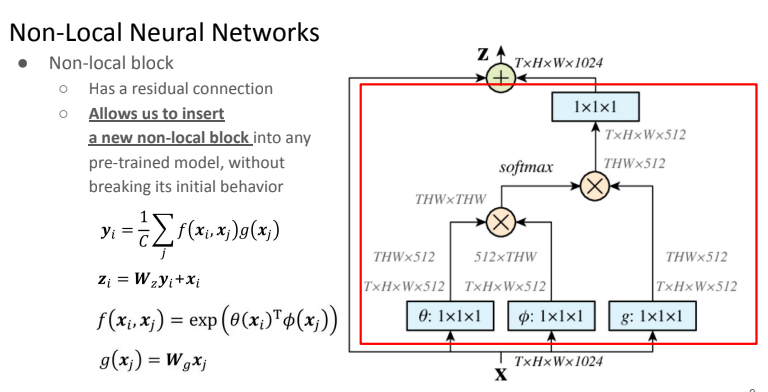

In [6]:
class NonLocalBlock3D(nn.Module):
    def __init__(self, in_channels, test_mode=False, dimension=3, sub_sample=True):
        super(NonLocalBlock3D, self).__init__()

        self.test_mode = test_mode
        self.dimension = dimension
        self.sub_sample = sub_sample

        self.in_channels = in_channels

        self.inter_channels = in_channels // 2
        if self.inter_channels == 0:
            self.inter_channels = 1

        max_pool_layer = nn.MaxPool3d(kernel_size=(1, 2, 2))

        #============================================================
        #make self.g , self.theta, self.phi
        #these are nn.Conv3d, 1x1x1, stride=1, padding=0
        #============================================================
        self.g = nn.Conv3d(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        self.theta = nn.Conv3d(in_channels=self.in_channels, out_channels=self.inter_channels,
                               kernel_size=1, stride=1, padding=0)

        self.phi = nn.Conv3d(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        #============================================================

        #============================================================
        #make self.W
        #in this part, self.W.weight and self.W.bias must initialize to 0
        #============================================================
        self.W = nn.Conv3d(in_channels=self.inter_channels, out_channels=self.in_channels,
                           kernel_size=1, stride=1, padding=0)
        nn.init.constant_(self.W.bias, 0)
        #============================================================

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x):
        '''
        :param x: (b, c, t, h, w)
        :return:
        '''
        batch_size = x.size(0)
        #============================================================
        #1. use self.g(x)
        #2. use self.theta(x)
        #3. use self.phi(x)
        #4. several matrix multiplication between previous return value
        #5. use self.W(y)
        #6. make z with x and self.W(y)
        #============================================================
        g_x = self.g(x)
        g_x = g_x.view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x)
        theta_x = theta_x.view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)

        phi_x = self.phi(x)
        phi_x = phi_x.view(batch_size, self.inter_channels, -1)

        f = torch.matmul(theta_x, phi_x)
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)
        
        if self.test_mode:
            print("x: {}".format(x.shape))
            print("g_x: {}".format(g_x.shape))
            print("theta_x: {}".format(theta_x.shape))
            print("phi_x: {}".format(phi_x.shape))
            print("f: {}".format(f.shape))
            print("y: {}".format(y.shape))

        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x
        #============================================================

        return z

## Define C3D Network

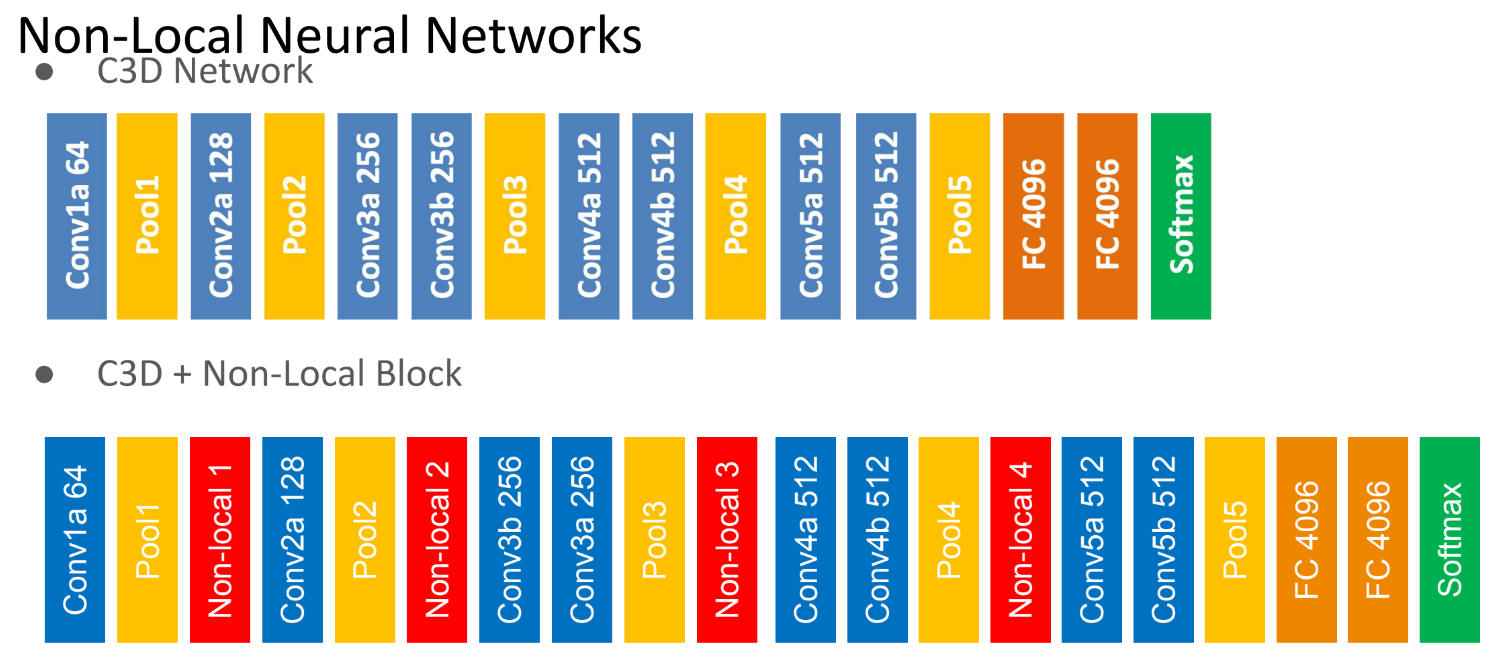

In [7]:
class C3D(nn.Module):
    """
    The C3D network.
    """

    def __init__(self, num_classes, pretrained=""):
        super(C3D, self).__init__()

        #============================================================
        #All of convolution layers use kernel_size (3,3,3) and padding (1, 1, 1)
        #conv1 3 -> 64
        #conv2 64 -> 128
        #conv3a 128 -> 256
        #conv3b 256 -> 256
        #conv4a 256 -> 512
        #conv4b 512 -> 512
        #conv5a 512 -> 512
        #conv5b 512 -> 512
        #fc6 (you need to find input channel size) -> 4096
        #fc7 4096 -> num_classes
        #============================================================

        # conv1 3 -> 64
        self.conv1 = nn.Conv3d(in_channels=3, out_channels=64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.nonlocal1 = NonLocalBlock3D(64)

        # conv2 64 -> 128
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.nonlocal2 = NonLocalBlock3D(128)

        # conv3a 128 -> 256
        self.conv3a = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        # conv3b 256 -> 256
        self.conv3b = nn.Conv3d(in_channels=256, out_channels=256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.nonlocal3 = NonLocalBlock3D(256)

        # conv4a 256 -> 512
        self.conv4a = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        # conv4b 512 -> 512
        self.conv4b = nn.Conv3d(in_channels=512, out_channels=512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.nonlocal4 = NonLocalBlock3D(512)

        # conv5a 512 -> 512
        self.conv5a = nn.Conv3d(in_channels=512, out_channels=512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        # conv5b 512 -> 512
        self.conv5b = nn.Conv3d(in_channels=512, out_channels=512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        # Flatten the output from conv layers to feed into fully connected layers
        self.fc6 = nn.Linear(8192, 4096)  # Assuming the input size is 16x112x112, you may need to adjust this
        self.fc7 = nn.Linear(4096, num_classes)

        #============================================================

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

        self.__init_weight()

        if pretrained:
            self.__load_pretrained_weights(pretrained)

    def forward(self, x):

        #============================================================
        #use all layer to forward
        #============================================================

        # conv1 -> relu -> pool1
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        # x = self.nonlocal1(x)

        # conv2 -> relu -> pool2
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        # x = self.nonlocal2(x)

        # conv3a -> relu -> conv3b -> relu -> pool3
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)
       #  x = self.nonlocal3(x)

        # conv4a -> relu -> conv4b -> relu -> pool4
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)
        # x = self.nonlocal4(x)

        # conv5a -> relu -> conv5b -> relu -> pool5
        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)
        # Flatten the output from conv layers to feed into fully connected layers
        x = x.view(x.size(0), -1)  # flattening

        # fc6 -> relu -> dropout
        x = self.relu(self.fc6(x))
        x = self.dropout(x)

        #============================================================
        logits = self.fc7(x)

        return logits

    def __load_pretrained_weights(self, model_path):
        """Initialiaze network."""
        corresp_name = {
                        # Conv1
                        "features.0.weight": "conv1.weight",
                        "features.0.bias": "conv1.bias",
                        # Conv2
                        "features.3.weight": "conv2.weight",
                        "features.3.bias": "conv2.bias",
                        # Conv3a
                        "features.6.weight": "conv3a.weight",
                        "features.6.bias": "conv3a.bias",
                        # Conv3b
                        "features.8.weight": "conv3b.weight",
                        "features.8.bias": "conv3b.bias",
                        # Conv4a
                        "features.11.weight": "conv4a.weight",
                        "features.11.bias": "conv4a.bias",
                        # Conv4b
                        "features.13.weight": "conv4b.weight",
                        "features.13.bias": "conv4b.bias",
                        # Conv5a
                        "features.16.weight": "conv5a.weight",
                        "features.16.bias": "conv5a.bias",
                         # Conv5b
                        "features.18.weight": "conv5b.weight",
                        "features.18.bias": "conv5b.bias",
                        # fc6
                        "classifier.0.weight": "fc6.weight",
                        "classifier.0.bias": "fc6.bias",
                        # fc7
                        "classifier.3.weight": "fc7.weight",
                        "classifier.3.bias": "fc7.bias",
                        }

        p_dict = torch.load(model_path)['state_dict']
        s_dict = self.state_dict()
        for name in p_dict:
            if name not in corresp_name:
                continue
            s_dict[corresp_name[name]] = p_dict[name]
        self.load_state_dict(s_dict)

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

## Set Network and Optimizer

In [8]:
net = C3D(num_classes=NUM_CLASSES)
net = net.cuda()

#net = C3D(num_classes=NUM_CLASSES).cuda()
#net = torch.nn.DataParallel(net).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Train and Test C3D

In [20]:
EPOCH_NUM = 1
for epoch in range(EPOCH_NUM):
    # train
    correct_epoch = 0
    loss_epoch = 0
    net.train()

    for i, batch in enumerate(train_video_dataloader):
        batch_clips = batch['clips']
        batch_labels = batch['labels']
        batch_clips = batch_clips.cuda()
        batch_labels = batch_labels.cuda()

        logits = net(batch_clips)

        loss = F.cross_entropy(logits, batch_labels)
        correct = (torch.argmax(logits, 1) == batch_labels).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss
        correct_epoch += correct

        if i % 100 == 0:
            print('Epoch %d, Batch %d: Loss is %.5f; Accuracy is %.5f'%(epoch+1, i, loss, correct/batch_clips.shape[0]))

    print('Epoch %d: Average loss is: %.5f; Average accuracy is: %.5f'%(epoch+1, loss_epoch / len(train_video_dataloader),
                                                                                correct_epoch / len(train_video_dataset)))

    # test
    correct_epoch = 0
    loss_epoch = 0
    net.eval()

    with torch.no_grad():
        for i, batch in enumerate(test_video_dataloader):
            batch_clips = batch['clips']
            batch_labels = batch['labels']
            batch_clips = batch_clips.cuda()
            batch_labels = batch_labels.cuda()

            logits = net(batch_clips)

            loss = F.cross_entropy(logits, batch_labels)
            correct = (torch.argmax(logits, 1) == batch_labels).sum()

            loss_epoch += loss
            correct_epoch += correct

    print('Test loss is %.5f; Accuracy is %.5f'%(loss_epoch / len(test_video_dataloader),
                                                                                correct_epoch / len(test_video_dataset)))


Epoch 1, Batch 0: Loss is 71.75650; Accuracy is 0.00000
Epoch 1, Batch 100: Loss is 2.03737; Accuracy is 0.40000
Epoch 1: Average loss is: 10.09374; Average accuracy is: 0.14873
Test loss is 2.23981; Accuracy is 0.24688
Epoch 2, Batch 0: Loss is 2.38481; Accuracy is 0.10000
Epoch 2, Batch 100: Loss is 1.48900; Accuracy is 0.60000
Epoch 2: Average loss is: 1.87553; Average accuracy is: 0.34471
Test loss is 1.98648; Accuracy is 0.33750
Epoch 3, Batch 0: Loss is 1.71976; Accuracy is 0.40000
Epoch 3, Batch 100: Loss is 1.02763; Accuracy is 0.70000
Epoch 3: Average loss is: 1.56712; Average accuracy is: 0.45582
Test loss is 1.83282; Accuracy is 0.46875
Epoch 4, Batch 0: Loss is 1.26023; Accuracy is 0.50000
Epoch 4, Batch 100: Loss is 1.31369; Accuracy is 0.50000
Epoch 4: Average loss is: 1.22812; Average accuracy is: 0.58005
Test loss is 2.24337; Accuracy is 0.42812
Epoch 5, Batch 0: Loss is 0.58626; Accuracy is 0.60000
Epoch 5, Batch 100: Loss is 0.85332; Accuracy is 0.70000
Epoch 5: Avera

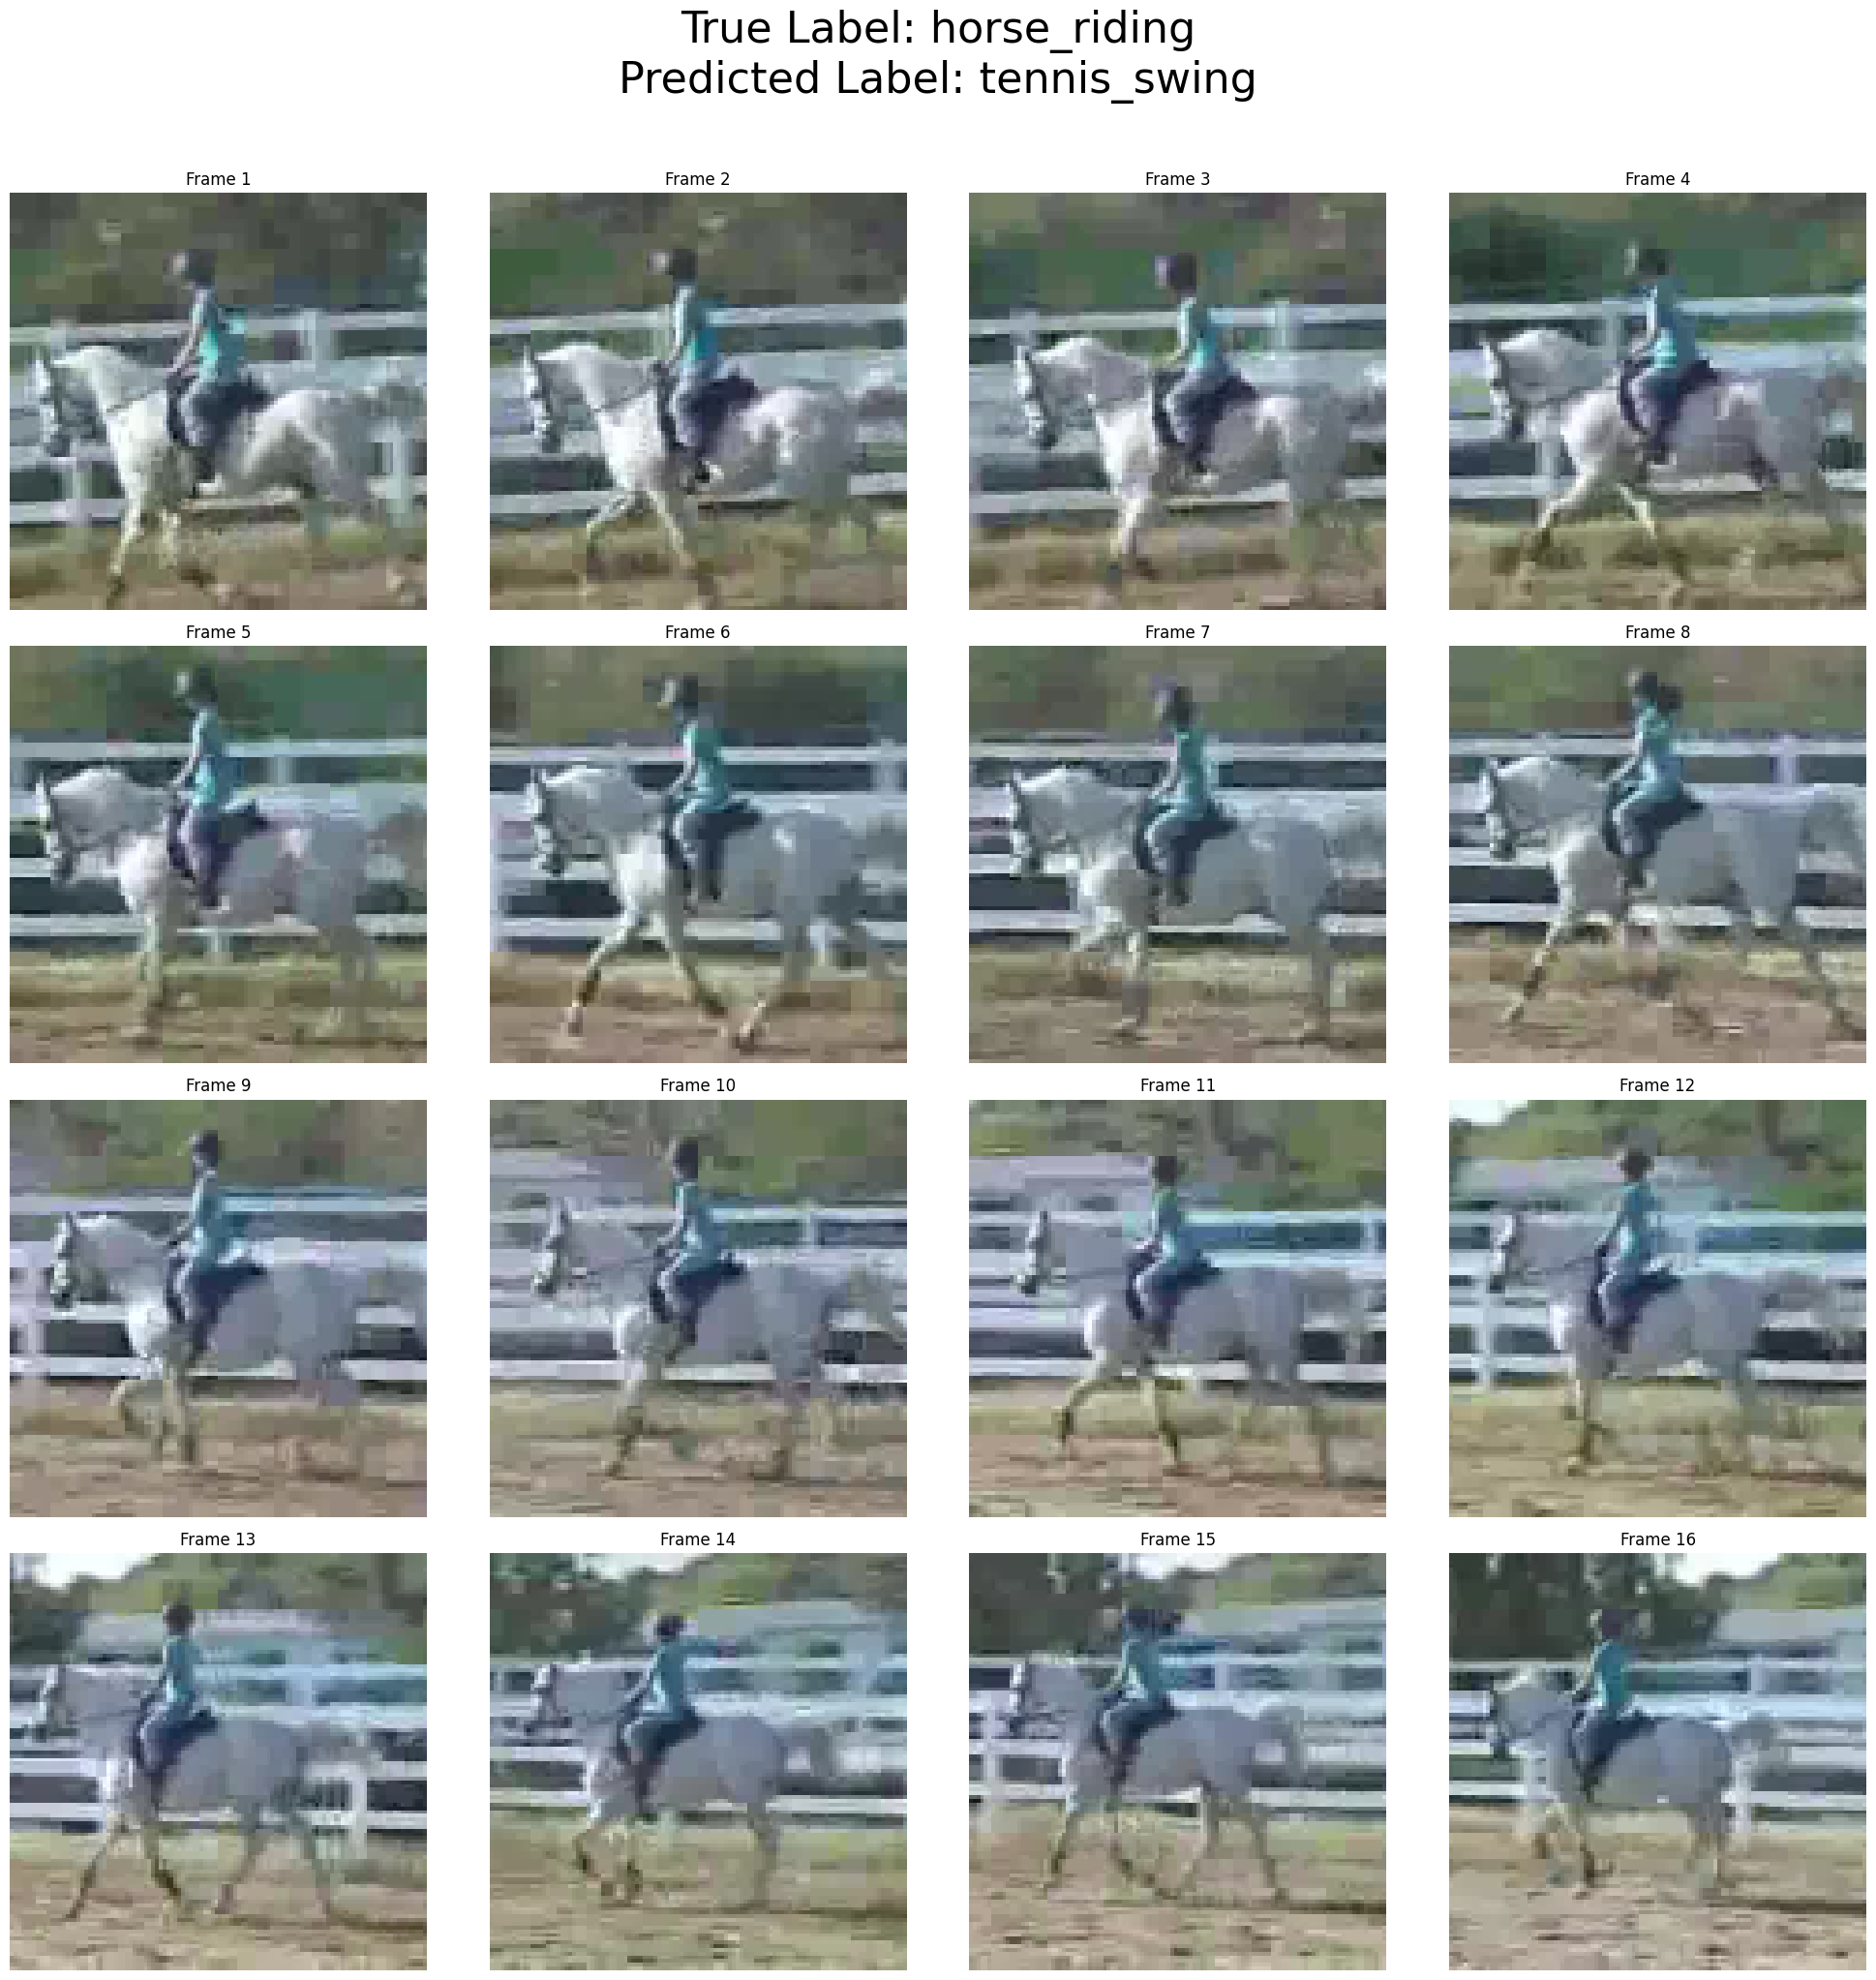

In [9]:
import numpy as np
import matplotlib.pyplot as plt

CLASS_LABELS = [
    "basketball", "biking", "diving", "golf_swing", "horse_riding",
    "soccer_juggling", "swing", "tennis_swing", "trampoline_jumping",
    "volleyball_spiking", "walking"
]

def restore_processed_frame(processed_frame, frame_mean):
    restored_frame = np.transpose(processed_frame, (1, 2, 0))
    restored_frame = restored_frame + frame_mean
    restored_frame = np.clip(restored_frame, 0, 255)
    restored_frame = restored_frame.astype(np.uint8)
    return restored_frame

def predict(net, clip):
    logits = net(torch.tensor(clip).unsqueeze(dim=0).cuda())
    predicted_class_index =  torch.argmax(logits, dim=1).item()
    return CLASS_LABELS[predicted_class_index]

def display_restored_clip(processed_clip, np_mean, true_label, predicted_label):
    num_frames = processed_clip.shape[1]
    rows = (num_frames + 3) // 4

    fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
    fig.suptitle(f'True Label: {true_label}\nPredicted Label: {predicted_label}',
                 fontsize=32, y=1.02)

    for i in range(num_frames):
        row = i // 4
        col = i % 4

        restored_frame = restore_processed_frame(processed_clip[:, i, :, :], np_mean[i])

        if rows > 1:
            ax = axes[row, col]
        else:
            ax = axes[col]

        ax.imshow(restored_frame)
        ax.set_title(f'Frame {i+1}', fontsize=12)
        ax.axis('off')

    for i in range(num_frames, rows * 4):
        row = i // 4
        col = i % 4
        if rows > 1:
            fig.delaxes(axes[row, col])
        else:
            fig.delaxes(axes[col])

    plt.tight_layout()
    plt.show()


def visualize_sample(dataset, index, model):
    sample = dataset[index]
    processed_clip = sample['clips']
    true_label_index = sample['labels']
    true_label = CLASS_LABELS[true_label_index]

    predicted_label = predict(net, processed_clip)

    display_restored_clip(processed_clip, np_mean, true_label, predicted_label)


visualize_sample(test_video_dataset, 0, net)

# Define TSM-ResNet50

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models


class TemporalShift(nn.Module):
    def __init__(self, net, n_segment=16, n_div=8):
        super(TemporalShift, self).__init__()
        self.net = net
        self.n_segment = n_segment
        self.fold_div = n_div

    def forward(self, x):
        x = self.shift(x, self.n_segment, fold_div=self.fold_div)
        return self.net(x)

    @staticmethod
    def shift(x, n_segment, fold_div=8):
        nt, c, h, w = x.size()  # nt는 n (배치 크기) * t (시간 세그먼트)
        n_batch = nt // n_segment
        x = x.view(n_batch, n_segment, c, h, w)

        fold = c // fold_div
        out = torch.zeros_like(x)

        #============================================================
        # Complete the Temporal Shift operation
        # Hint: You need to shift a portion of the channels to the left and another portion to the right
        #============================================================

        # Shift left
        out[:, :-1, :fold] = x[:, 1:, :fold]

        # Shift right
        out[:, 1:, fold:2*fold] = x[:, :-1, fold:2*fold]

        # Keep the rest unchanged
        out[:, :, 2*fold:] = x[:, :, 2*fold:]

        #============================================================

        return out.view(nt, c, h, w)



class TSM_ResNet(nn.Module):
    def __init__(self, num_classes, n_segment=16):
        super(TSM_ResNet, self).__init__()
        self.n_segment = n_segment
        self.base_model = models.resnet50(pretrained=True)

        #============================================================
        # Apply TemporalShift module to each ResNet layer
        # You can access each layer of the ResNet model using syntax like self.base_model.layer1
        #============================================================

        self.base_model.layer1 = TemporalShift(self.base_model.layer1, n_segment=self.n_segment)
        self.base_model.layer2 = TemporalShift(self.base_model.layer2, n_segment=self.n_segment)
        self.base_model.layer3 = TemporalShift(self.base_model.layer3, n_segment=self.n_segment)
        self.base_model.layer4 = TemporalShift(self.base_model.layer4, n_segment=self.n_segment)

        #============================================================

        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        # x shape: (batch_size, channels, num_segments, height, width)
        b, c, t, h, w = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # (b, t, c, h, w)

        #============================================================
        # Reshape the input tensor for 2D CNN
        x = x.view(-1, c, h, w)  # (batch_size * num_segments, channels, height, width)
        #============================================================

        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = self.base_model.layer2(x)
        x = self.base_model.layer3(x)
        x = self.base_model.layer4(x)

        x = self.base_model.avgpool(x)
        x = x.view(b, t, -1).mean(1)
        x = self.base_model.fc(x)
        return x

In [11]:
net = TSM_ResNet(num_classes=NUM_CLASSES)
net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/devrok/.conda/envs/snuenv_pt/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and Test TSM

In [12]:
EPOCH_NUM = 10

for epoch in range(EPOCH_NUM):
    # train
    correct_epoch = 0
    loss_epoch = 0
    net.train()

    for i, batch in enumerate(train_video_dataloader):
        batch_clips = batch['clips']
        batch_labels = batch['labels']
        batch_clips = batch_clips.cuda()
        batch_labels = batch_labels.cuda()

        logits = net(batch_clips)

        loss = F.cross_entropy(logits, batch_labels)
        correct = (torch.argmax(logits, 1) == batch_labels).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss
        correct_epoch += correct

        if i % 100 == 0:
            print('Epoch %d, Batch %d: Loss is %.5f; Accuracy is %.5f'%(epoch+1, i, loss, correct/batch_clips.shape[0]))

    print('Epoch %d: Average loss is: %.5f; Average accuracy is: %.5f'%(epoch+1, loss_epoch / len(train_video_dataloader),
                                                                                correct_epoch / len(train_video_dataset)))

    # test
    correct_epoch = 0
    loss_epoch = 0
    net.eval()

    with torch.no_grad():
        for i, batch in enumerate(test_video_dataloader):
            batch_clips = batch['clips']
            batch_labels = batch['labels']
            batch_clips = batch_clips.cuda()
            batch_labels = batch_labels.cuda()

            logits = net(batch_clips)

            loss = F.cross_entropy(logits, batch_labels)
            correct = (torch.argmax(logits, 1) == batch_labels).sum()

            loss_epoch += loss
            correct_epoch += correct

    print('Test loss is %.5f; Accuracy is %.5f'%(loss_epoch / len(test_video_dataloader),
                                                                                correct_epoch / len(test_video_dataset)))

Epoch 1, Batch 0: Loss is 2.38730; Accuracy is 0.20000
Epoch 1, Batch 100: Loss is 0.06004; Accuracy is 1.00000
Epoch 1: Average loss is: 0.86139; Average accuracy is: 0.75241
Test loss is 0.74924; Accuracy is 0.75938
Epoch 2, Batch 0: Loss is 0.52569; Accuracy is 0.80000
Epoch 2, Batch 100: Loss is 0.28824; Accuracy is 0.90000
Epoch 2: Average loss is: 0.28770; Average accuracy is: 0.91339
Test loss is 0.66232; Accuracy is 0.77500
Epoch 3, Batch 0: Loss is 0.06997; Accuracy is 1.00000
Epoch 3, Batch 100: Loss is 0.39747; Accuracy is 0.90000
Epoch 3: Average loss is: 0.18793; Average accuracy is: 0.94401
Test loss is 0.45662; Accuracy is 0.85938
Epoch 4, Batch 0: Loss is 0.04455; Accuracy is 1.00000
Epoch 4, Batch 100: Loss is 0.06886; Accuracy is 1.00000
Epoch 4: Average loss is: 0.09679; Average accuracy is: 0.97288
Test loss is 0.63333; Accuracy is 0.83125
Epoch 5, Batch 0: Loss is 0.05959; Accuracy is 1.00000
Epoch 5, Batch 100: Loss is 0.57931; Accuracy is 0.80000
Epoch 5: Average

# Define NonLocal-ResNet50

In [12]:
class NonLocal_ResNet(nn.Module):
    def __init__(self, num_classes, n_segment=16):
        super(NonLocal_ResNet, self).__init__()
        self.n_segment = n_segment
        self.base_model = models.resnet50(pretrained=True)

        # Get the number of output channels for each layer
        self.layer1_channels = self.base_model.layer1[-1].conv3.out_channels
        self.layer2_channels = self.base_model.layer2[-1].conv3.out_channels
        self.layer3_channels = self.base_model.layer3[-1].conv3.out_channels
        self.layer4_channels = self.base_model.layer4[-1].conv3.out_channels

        #============================================================
        # Add Non-local blocks after each ResNet block
        #============================================================

        self.non_local1 = NonLocalBlock3D(self.layer1_channels)
        self.non_local2 = NonLocalBlock3D(self.layer2_channels)
        self.non_local3 = NonLocalBlock3D(self.layer3_channels)
        self.non_local4 = NonLocalBlock3D(self.layer4_channels)

        #============================================================

        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        # x shape: (batch_size, channels, num_segments, height, width)
        b, c, t, h, w = x.size()
        x = x.permute(0, 2, 1, 3, 4).contiguous()  # (b, t, c, h, w)
        x = x.view(b * t, c, h, w)

        x = self.base_model.conv1(x)
        x = self.base_model.bn1(x)
        x = self.base_model.relu(x)
        x = self.base_model.maxpool(x)

        x = self.base_model.layer1(x)
        x = x.view(b, t, x.size(1), x.size(2), x.size(3)).transpose(1, 2).contiguous()
        x = self.non_local1(x)
        x = x.transpose(1, 2).contiguous().view(b*t, -1, x.size(3), x.size(4))

        x = self.base_model.layer2(x)
        x = x.view(b, t, x.size(1), x.size(2), x.size(3)).transpose(1, 2).contiguous()
        x = self.non_local2(x)
        x = x.transpose(1, 2).contiguous().view(b*t, -1, x.size(3), x.size(4))

        x = self.base_model.layer3(x)
        x = x.view(b, t, x.size(1), x.size(2), x.size(3)).transpose(1, 2).contiguous()
        x = self.non_local3(x)
        x = x.transpose(1, 2).contiguous().view(b*t, -1, x.size(3), x.size(4))

        x = self.base_model.layer4(x)
        x = x.view(b, t, x.size(1), x.size(2), x.size(3)).transpose(1, 2).contiguous()
        x = self.non_local4(x)
        x = x.transpose(1, 2).contiguous().view(b*t, -1, x.size(3), x.size(4))

        x = self.base_model.avgpool(x)
        x = x.view(b, t, -1).mean(1)
        x = self.base_model.fc(x)
        return x

In [13]:
net = NonLocal_ResNet(num_classes=NUM_CLASSES)
net = net.cuda()

optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [14]:
EPOCH_NUM = 5
for epoch in range(EPOCH_NUM):
    # train
    correct_epoch = 0
    loss_epoch = 0
    net.train()

    for i, batch in enumerate(train_video_dataloader):
        batch_clips = batch['clips']
        batch_labels = batch['labels']
        batch_clips = batch_clips.cuda()
        batch_labels = batch_labels.cuda()

        logits = net(batch_clips)

        loss = F.cross_entropy(logits, batch_labels)
        correct = (torch.argmax(logits, 1) == batch_labels).sum()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch += loss
        correct_epoch += correct

        if i % 100 == 0:
            print('Epoch %d, Batch %d: Loss is %.5f; Accuracy is %.5f'%(epoch+1, i, loss, correct/batch_clips.shape[0]))

    print('Epoch %d: Average loss is: %.5f; Average accuracy is: %.5f'%(epoch+1, loss_epoch / len(train_video_dataloader),
                                                                                correct_epoch / len(train_video_dataset)))

    # test
    correct_epoch = 0
    loss_epoch = 0
    net.eval()

    with torch.no_grad():
        for i, batch in enumerate(test_video_dataloader):
            batch_clips = batch['clips']
            batch_labels = batch['labels']
            batch_clips = batch_clips.cuda()
            batch_labels = batch_labels.cuda()

            logits = net(batch_clips)

            loss = F.cross_entropy(logits, batch_labels)
            correct = (torch.argmax(logits, 1) == batch_labels).sum()

            loss_epoch += loss
            correct_epoch += correct

    print('Test loss is %.5f; Accuracy is %.5f'%(loss_epoch / len(test_video_dataloader),
                                                                                correct_epoch / len(test_video_dataset)))

Epoch 1, Batch 0: Loss is 0.01273; Accuracy is 1.00000
Epoch 1, Batch 100: Loss is 0.00842; Accuracy is 1.00000
Epoch 1: Average loss is: 0.02147; Average accuracy is: 0.99650
Test loss is 0.84359; Accuracy is 0.80313
Epoch 2, Batch 0: Loss is 0.01063; Accuracy is 1.00000
Epoch 2, Batch 100: Loss is 0.00998; Accuracy is 1.00000
Epoch 2: Average loss is: 0.03947; Average accuracy is: 0.99213
Test loss is 0.76317; Accuracy is 0.79375
Epoch 3, Batch 0: Loss is 0.00354; Accuracy is 1.00000
Epoch 3, Batch 100: Loss is 0.01233; Accuracy is 1.00000
Epoch 3: Average loss is: 0.11864; Average accuracy is: 0.96150
Test loss is 0.92146; Accuracy is 0.75938
Epoch 4, Batch 0: Loss is 0.37318; Accuracy is 0.90000
Epoch 4, Batch 100: Loss is 0.01973; Accuracy is 1.00000
Epoch 4: Average loss is: 0.12601; Average accuracy is: 0.95451
Test loss is 1.07313; Accuracy is 0.75313
Epoch 5, Batch 0: Loss is 0.04570; Accuracy is 1.00000
Epoch 5, Batch 100: Loss is 0.79129; Accuracy is 0.70000
Epoch 5: Average